# Embeddings from scratch

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
sentences = [
    'La inteligencia artificial es la hostia',
    'El procesamiento de lenguaje natural es una rama del aprendizaje profundo',
    "Me encanta estudar inteligencia artifical",
    "Las películas de inteligencia artificial me encantan",
    "El arendizaje profundo es una subcategoría de la inteligencia artificial",
    "Los embeddings de palabras capturan semántica",
    "PyTorch es una herramienta para aprendiaje profundo e inteligencia artificial",
]

In [18]:
class SkipGramData(Dataset):
    def __init__(self, corpus, window_sz= 2):
        super().__init__
        self.corpus = corpus
        self.window = window_sz
        self.vocab = list(set(token.lower() for sentence in self.corpus for token in sentence.split())) # set elimina dups y no mantiene el orden
        self.word2idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx2word = {idx: word for word, idx in self.word2idx.items()}
        self.data = self.gen_dataset()

    def gen_dataset(self):
        # Metod for enventanado
        data = []
        for sentence in self.corpus:
            text = sentence.lower().split()
            print(text)
            for center_idx, center_word in enumerate(text):
                for offset in range(-self.window, self.window +1):
                    context_idx = center_idx + offset
                    if context_idx < 0 or context_idx >= len(text) or context_idx == center_idx: continue
                    context_word = text[context_idx]
                    data.append((self.word2idx[center_word], self.word2idx[context_word]))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
class SkipGram(nn.Module):
    def __init__(self, vocab_sz, embed_sz):
        super().__init__()
        self.embed_layer = nn.Linear(vocab_sz, embed_sz, bias = False)
        self.output_layer = nn.Linear(embed_sz, vocab_sz)

    def forward(self, x):
        return self.output_layer(self.embed_layer(x))

In [23]:
def train_skipgram(model, loss_function, optimizer, data_loader, epochs=100):
    for epoch in range(epochs):
        total_loss = 0
        for center, context in data_loader:
            center_vector = torch.zeros(len(data_loader.dataset.vocab))
            center_vector[center] = 1.0
            center_vector = center_vector.unsqueeze(0)
            scores = model(center_vector)

            loss = loss_function(scores, torch.tensor([context]))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'epoch: {epoch}, loss: {total_loss/len(data_loader)}')

In [24]:
learning_rate = 0.0001

dataset = SkipGramData(sentences)
print(type(dataset.data))
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
model = SkipGram(len(dataset.vocab), embed_sz=300)
optimizer = optim.Adam(model.parameters(), lr= learning_rate)
loss_function = nn.CrossEntropyLoss()

train_skipgram(model, loss_function, optimizer, data_loader, epochs=1000)
for center_idx, context_idx in dataset.data:
    print(dataset.idx2word[center_idx],dataset.idx2word[context_idx])

['la', 'inteligencia', 'artificial', 'es', 'la', 'hostia']
['el', 'procesamiento', 'de', 'lenguaje', 'natural', 'es', 'una', 'rama', 'del', 'aprendizaje', 'profundo']
['me', 'encanta', 'estudar', 'inteligencia', 'artifical']
['las', 'películas', 'de', 'inteligencia', 'artificial', 'me', 'encantan']
['el', 'arendizaje', 'profundo', 'es', 'una', 'subcategoría', 'de', 'la', 'inteligencia', 'artificial']
['los', 'embeddings', 'de', 'palabras', 'capturan', 'semántica']
['pytorch', 'es', 'una', 'herramienta', 'para', 'aprendiaje', 'profundo', 'e', 'inteligencia', 'artificial']
<class 'list'>
epoch: 0, loss: 3.528258436181572
epoch: 1, loss: 3.505415624447083
epoch: 2, loss: 3.483098129208168
epoch: 3, loss: 3.4605692303582525
epoch: 4, loss: 3.4381961929664184
epoch: 5, loss: 3.4154967377694807
epoch: 6, loss: 3.3924944882982233
epoch: 7, loss: 3.36968201465821
epoch: 8, loss: 3.346358530976799
epoch: 9, loss: 3.32279042983323
epoch: 10, loss: 3.299121963843871
epoch: 11, loss: 3.27501987607

In [10]:
for x, y in data_loader:
    print(x, y)

tensor([11]) tensor([25])
tensor([16]) tensor([9])
tensor([9]) tensor([2])
tensor([18]) tensor([33])
tensor([30]) tensor([4])
tensor([30]) tensor([15])
tensor([15]) tensor([7])
tensor([27]) tensor([33])
tensor([13]) tensor([30])
tensor([32]) tensor([2])
tensor([18]) tensor([28])
tensor([0]) tensor([18])
tensor([5]) tensor([3])
tensor([2]) tensor([20])
tensor([16]) tensor([9])
tensor([19]) tensor([26])
tensor([21]) tensor([18])
tensor([32]) tensor([9])
tensor([18]) tensor([30])
tensor([16]) tensor([25])
tensor([5]) tensor([12])
tensor([9]) tensor([32])
tensor([17]) tensor([0])
tensor([26]) tensor([4])
tensor([4]) tensor([2])
tensor([21]) tensor([13])
tensor([28]) tensor([16])
tensor([24]) tensor([28])
tensor([16]) tensor([21])
tensor([2]) tensor([4])
tensor([11]) tensor([22])
tensor([5]) tensor([18])
tensor([2]) tensor([0])
tensor([16]) tensor([14])
tensor([4]) tensor([13])
tensor([9]) tensor([21])
tensor([15]) tensor([30])
tensor([20]) tensor([32])
tensor([9]) tensor([16])
tensor([33])

In [34]:
def plot_embeddings(embedings, word2idx):
    num_samples = len(word2idx)
    tsne = TSNE(n_components=2, random_state=0)
    vectors = tsne.fit_transform(embeddings)
    plt.figure(figsize=(20,10))
    for word, idx in word2idx.items():
        plt.scatter(vectors[idx, 0], vectors[idx, 1])
        plt.annotate(word, xy=(vectors[idx, 0], vectors[idx, 1]), xytext=(5,2), 
                    textcoords='offset points', ha='right', va='bottom')
    plt.title('Word Embeddings Visualized using t-SNE')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel(True)
    plt.show()

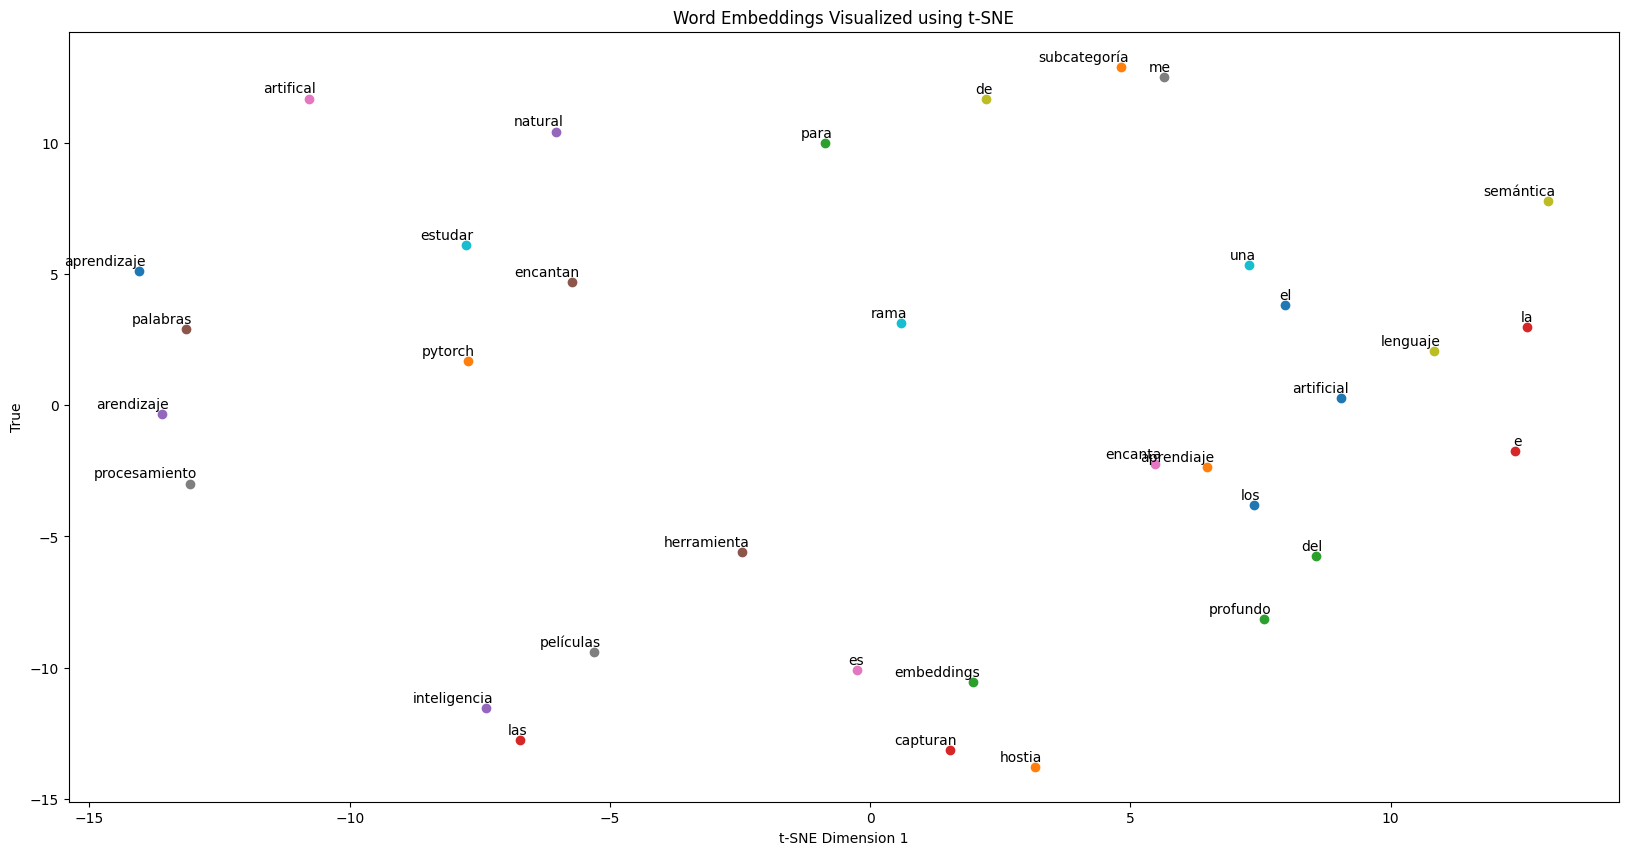

In [35]:
embeddings = model.embed_layer.weight.detach().numpy()
plot_embeddings(embeddings, dataset.word2idx)